<a href="https://colab.research.google.com/github/v-spitsyn/Avito_rent/blob/master/modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The notebook describes building a model for forecasting rent prices of residential flats in Moscow. Two algorithms that were tried are linear regression and random forest.

In [0]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
import statsmodels.api as sm
warnings.filterwarnings("ignore")

In [164]:
from google.colab import drive
drive.mount('/content/gdrive')
with open('/content/gdrive/My Drive/clean_df', 'rb') as f:
    df = pickle.load(f)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data

Every row in the dataframe corresponds to a flat. Below is description of the columns the dataframe contains. Units of measurement are given in square brackets. *Rent* is the target variable.

* *rent* (continuous) - rental cost of the flat [thousands of roubles]
* *area* (continuous) - area of the flat [square metres]
* *1st_floor* (binary) - 1 if the flat is on the first floor, 0 otherwise
* *last_floor* (binary) - 1 if the flat is on the last floor, 0 otherwise
* *studio* (binary) - 1 if the flat is a studio, 0 otherwise
* *station_dist* (continuous) - distance to the closest underground station [hundreds of metres]
* *center_dist* (continuous) - distance to Kilometre Zero (which is near Red Square) [kilometres]
* *circle* (binary) - 1 if the closest underground station is on the circle line, 0 otherwise
* *house_type* (categorical) - type of the house: block, brick, monolithic or panel
* *landlord* (categorical) - name of the company/person that rents out the flat
* *landlord_type* (categorical) - type of the landlord: owner, agency or developer
* *commission* (continuous) - commission charged by the landlord (0 if there is no commission) [percentage of the rental cost]
* *deposit* (continuous) - deposit charged by the landlord (0 if there is no deposit) [percentage of the rental cost]
* *fridge* (binary) - 1 if there is a fridge in the flat, 0 otherwise
* *ac* (binary) - 1 if there is air-conditioner in the flat, 0 otherwise
* *balcony* (binary) - 1 if there is a balcony/loggia in  the flat, 0 otherwise
* *microwave* (binary) - 1 if there is a microwave oven in the flat, 0 otherwise
* *parking* (binary) - 1 if a parking lot is rented along with the flat, 0 otherwise
*  *stove*  (binary) - 1 if there is a stove in  the flat, 0 otherwise
* *tv* (binary) - 1 if there is a tv set in  the flat, 0 otherwise
* *wash_machine* (binary) - 1 if there is a washing machine in  the flat, 0 otherwise
* *wifi* (binary) - 1 if there is Wi-Fi in the flat, 0 otherwise




There are about 2.5 thousand observations in the dataset.

In [114]:
df.shape

(2523, 22)

# Exploratory data analysis

The boxplots below show that the median rent price is 36 thousand for flats from agencies and owners and 40 thousand for flats offered by developers. The boxplot of rent per square metre permits to see the differences between distributions better.

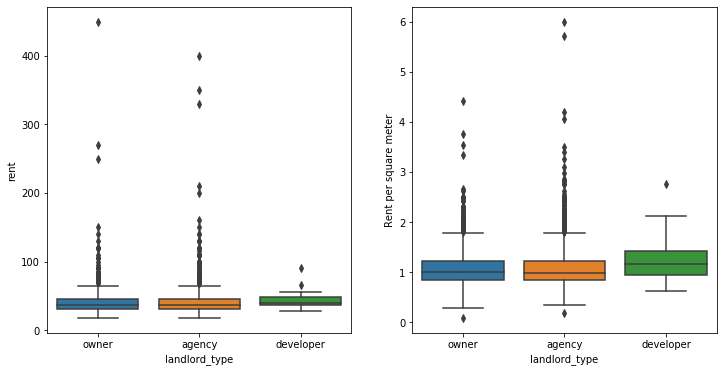

In [165]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sb.boxplot(x='landlord_type', y='rent', data=df)
plt.subplot(1, 2, 2)
sb.boxplot(x='landlord_type', y=df['rent']/df['area'], data=df)
plt.ylabel('Rent per square meter')
plt.show()

In [166]:
df.groupby('landlord_type').median()['rent']

landlord_type
agency       36.00
developer    40.15
owner        36.00
Name: rent, dtype: float64

The histogram of *commission* shows that 0%, 50% and 100% are by far the most popular options. The scatterplot of *rent* vs *commission* does not allow to find any relationship between the variables (although for all flats with rent cost above 150 thousand commission was zero, so they are not depicted on the plot). The reason might be that size of commission is  tied to a particular agency rather than rental cost of the flat.

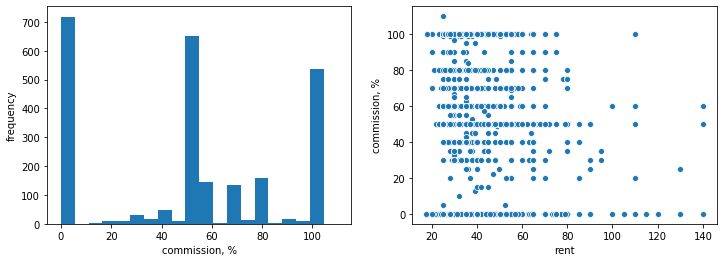

In [167]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df.loc[df['landlord_type'] != 'landlord', 'commission'], bins=20)
plt.xlabel('commission, %')
plt.ylabel('frequency')
plt.subplot(1, 2, 2)
sb.scatterplot('rent', 'commission', data=df[df['rent']<150])
plt.ylabel('commission, %')
plt.show()

Now we try to find out if there is a dependency between commissions agencies charge and rental cost of flats they offer. First, we select agencies that rent out at least 6 apartments at the moment. Then for every such agency we find the average rent price of its flats and the average commision the agency takes. 

In [0]:
largest_landlords = (df[df['landlord_type'] != 'owner']
                    .groupby('landlord')
                    .count()
                    .query('rent >= 6')
                    .sort_values('rent', ascending=False)
                    .index)
landlords_by_rent = (df[df['landlord'].isin(largest_landlords)]
                    .groupby('landlord')
                    .mean()['rent'])
landlords_by_commission = (df[df['landlord'].isin(largest_landlords)]
                        .groupby('landlord')
                        .mean()['commission'])

The only pattern we can see from the scatterplot below is that agencies with average rental cost below 35 thousand tend to charge slightly higher commissions (in % of the rent). Number of agencies with the average rent price above 50 thousand is quite small and agencies that take zero commission present only in that price segment.

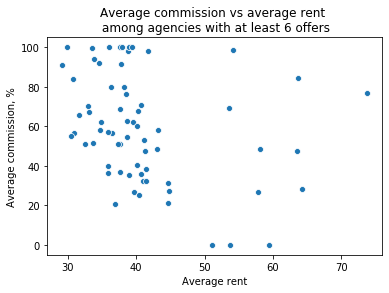

In [169]:
sb.scatterplot('rent', 'commission', 
               data=pd.merge(landlords_by_rent, 
                             landlords_by_commission, 
                             on='landlord')
               )
plt.xlabel('Average rent')
plt.ylabel('Average commission, %')
plt.title('Average commission vs average rent \n among agencies with at least 6 offers')
plt.show()

The following picture shows that there is a very narrow range of values that deposit can take: it may be 0, 50, 100, 150, 200 or 300 percent of the rent. 100% is the most frequent value while deposits greater than 100% are extremely rare.

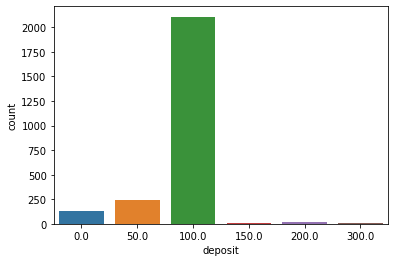

In [120]:
sb.countplot(x='deposit', data=df)
plt.show()

Some more statistics on commissions and deposits:

In [121]:
zero_commission = df[(df['commission']==0) & (df['landlord_type'] != 'owner')]
print('Number of agent offers with zero commission: {} ({}%)'
    .format(zero_commission.shape[0], 
            round(zero_commission.shape[0]/df[df['landlord_type'] != 'owner'].shape[0]*100, 
                  2)
            )
)
print('Number of offers with 100% deposit: {} ({}%)'
    .format(df[df['deposit']==100].shape[0], 
            round(df[df['deposit']==100].shape[0]/df.shape[0]*100, 2)
            )
    )

Number of agent offers with zero commission: 220 (13.41%)
Number of offers with 100% deposit: 2108 (83.55%)


In [0]:
#droping the columns we will not need any more
df.drop(['landlord', 'commission', 'deposit'], axis=1, inplace=True)

It is necessary to get rid of observations that are in some sense extreme. To do it we will observe the distributions of rent prices, areas of flats and distances to the closest station. Flats with rental cost above 90 thousand are rare and their price to a large extent is explained by factors that are not present in our dataset. The number of flats that have area greater than 60 square metres or are farther than 3 kilometres away from an underground station is also small. After removing such flats there is about 2.3 thousand observations left. 

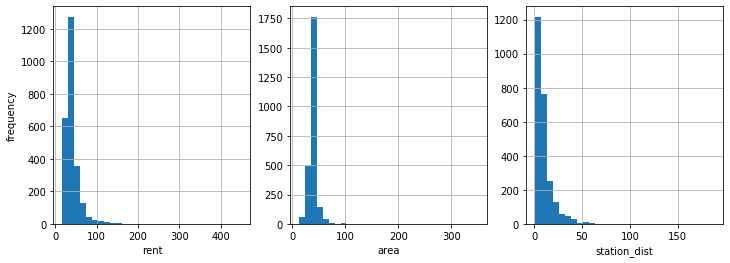

In [123]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
df['rent'].hist(bins=30)
plt.xlabel('rent')
plt.ylabel('frequency')
plt.subplot(1, 3, 2)
df['area'].hist(bins=30)
plt.xlabel('area')
plt.subplot(1, 3, 3)
df['station_dist'].hist(bins=30)
plt.xlabel('station_dist')
plt.show()

In [0]:
df.drop(df[df['rent'] > 90].index, inplace=True)
df.drop(df[df['area'] > 60].index, inplace=True)
df.drop(df[df['station_dist'] > 30].index, inplace=True)

In [125]:
df.shape

(2325, 19)




We will use two algorithms for fitting: linear regression and random forest. Mean absolute error (MAE) and mean absolute percentage error (MAPE) will be used as quality metrics. 

Each model will be tested with two feature sets: bases set and full set. Base features are the ones included in *base* array:

In [0]:
base = ['area', '1st_floor', 'last_floor', 'studio', 'station_dist',
        'center_dist', 'circle', 'house_type', 'landlord_type']

Feature matrix with basic features will be called *X_base* and feature matrix with full set of features - just *X*. Target vectors corresponding to the base and full feature set will be called *y_base* and *y* respectevely. 

After dummy encoding 'block' becomes the basic level for *house_type* and 'agency' becomes the basic level for *landlord_type*:

In [0]:
X_base = pd.get_dummies(df[base],
                        columns=['house_type', 'landlord_type'],
                        drop_first=True)

# Linear Regression

For linear regression we will use log-linear form, i.e. *rent* will be log transformed while explanatory variables won't. The coefficients of the regression thus show what is a percentage change of rent in response to a unit change of a regressor. The sum of absolute values of residuals devided by number of observations is then approximately equal to MAPE. The estimator used is OLS with White error covariance matrix.

In [0]:
ln_y_base = np.log(df['rent'])

In [0]:
#spliting log-target and feature matrix into train and test sets
X_base_train, X_base_test, ln_y_base_train, ln_y_base_test = train_test_split(X_base, ln_y_base, 
                                                                              test_size=0.2,
                                                                              random_state=123
                                                                              )

The first linear regression wil include the whole base feature set:

In [130]:
lin_base1 = (sm.OLS(ln_y_base_train, sm.add_constant(X_base_train))
                .fit(cov_type='HC0'))
print(lin_base1.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     170.0
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          8.62e-288
Time:                        16:47:57   Log-Likelihood:                 391.79
No. Observations:                1860   AIC:                            -757.6
Df Residuals:                    1847   BIC:                            -685.7
Df Model:                          12                                         
Covariance Type:                  HC0                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

The model suggests that there is no significant difference (with other factors kept fixed) 
- between flats offered by owners and agencies
- between flats in block and panel houses  

To investigate how reasonable are these conclusions we observe the boxplots. Indeed, the distributions of rent per square metre for flats from owners and flats from agencies are very similar. Absence of difference between panel and block houses is not obvious, however there can be latent factors that depend on the house type but are missing in the dataset.

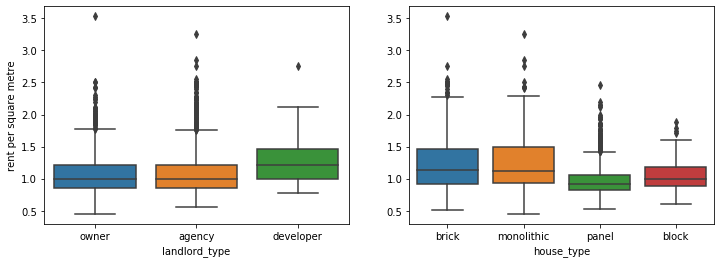

In [161]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sb.boxplot(x=df['landlord_type'], y=df['rent']/df['area'])
plt.ylabel('rent per square metre')
plt.subplot(1, 2, 2)
sb.boxplot(x=df['house_type'], y=df['rent']/df['area'])
plt.show()

Now we exclude the dummy variables *house_type_panel* and *landlord_type_owner*, which leads us to the second version of the model on base feature set. As we can see, R squared has not changed.

In [132]:
lin_base2 = sm.OLS(ln_y_base_train, sm.add_constant(X_base_train.drop(['house_type_panel', 
                                                                       'landlord_type_owner'], 
                                                                        axis=1
                                                                        )
                                                )
                    ).fit(cov_type='HC0')
print(lin_base2.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     202.1
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          6.01e-288
Time:                        16:47:58   Log-Likelihood:                 391.32
No. Observations:                1860   AIC:                            -760.6
Df Residuals:                    1849   BIC:                            -699.8
Df Model:                          10                                         
Covariance Type:                  HC0                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Now we save predictions of the model on the train and test data to compare its performance with a regression built on the full feature set:

In [0]:
ln_y_base_train_pred = lin_base2.predict(sm.add_constant(X_base_train.drop(['house_type_panel',
                                                                            'landlord_type_owner',
                                                                            ], 
                                                                            axis=1
                                                                            )
                                                            )
                                            )
ln_y_base_test_pred = lin_base2.predict(sm.add_constant(X_base_test.drop(['house_type_panel',
                                                                          'landlord_type_owner'
                                                                         ], 
                                                                        axis=1
                                                                        )
                                                        )
                                        )

The variables in *extra_params* list present features that will be added to the model. Their union with the base set constitutes full feature set.

In [0]:
extra_params = ['wifi', 'tv', 'fridge', 'stove', 'microwave', 'ac',
                'wash_machine', 'balcony', 'parking']

For some observations extra parameters are missing - those are the rows where all extra parameters are equal to 0. We now remove them from the dataset,

In [0]:
df2 = df[df.apply(lambda l: any(l[extra_params]) == True,
                  axis=1)
        ]

and find subsets of X_base and y_base where extra parameters are not missing:

In [0]:
train_ind = X_base_train.index.intersection(df2.index)
test_ind = X_base_test.index.intersection(df2.index)
ln_y_train = ln_y_base_train.loc[train_ind]
ln_y_test = ln_y_base_test.loc[test_ind]
X_train = pd.get_dummies(df2.loc[train_ind].drop('rent', axis=1),
                         columns=['house_type', 'landlord_type'],
                         drop_first=True)
X_test = pd.get_dummies(df2.loc[test_ind].drop('rent', axis=1),
                        columns=['house_type', 'landlord_type'],
                        drop_first=True)                        

After removing observations with missing extra parameters both train and test sets got shrunk by around 40%:

In [138]:
print(X_base_train.shape, X_train.shape)
print(X_base_test.shape, X_test.shape)

(1860, 12) (1329, 21)
(465, 12) (332, 21)


The first regression on full feature set (excluding variables that were found to be not significant):

In [139]:
lin1 = sm.OLS(ln_y_train, sm.add_constant(X_train.drop(['house_type_panel',
                                                        'landlord_type_owner',], 
                                                        axis=1
                                                        )
                                            )
                ).fit(cov_type='HC0')
print(lin1.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     104.6
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          3.81e-246
Time:                        16:48:00   Log-Likelihood:                 402.87
No. Observations:                1329   AIC:                            -765.7
Df Residuals:                    1309   BIC:                            -661.9
Df Model:                          19                                         
Covariance Type:                  HC0                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

From regression statistics we can see that adding extra parameters does not increase R squared much. We remove the variables *fridge* and *wash_machine* as having high p-values. Now, the second version of the model on the (reduced) full feature set:

In [140]:
lin2 = sm.OLS(ln_y_train, sm.add_constant(X_train.drop(['house_type_panel', 
                                                        'landlord_type_owner',
                                                        'fridge',
                                                        'wash_machine'
                                                        ], 
                                                        axis=1
                                                        )
                                            )
                ).fit(cov_type='HC0')
print(lin2.summary())

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     116.7
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          8.55e-248
Time:                        16:48:00   Log-Likelihood:                 402.70
No. Observations:                1329   AIC:                            -769.4
Df Residuals:                    1311   BIC:                            -675.9
Df Model:                          17                                         
Covariance Type:                  HC0                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Again, deleting variables does not lead to R squared decreasing. 

In [0]:

ln_y_train_pred = lin2.predict(sm.add_constant(X_train.drop(['house_type_panel', 
                                                             'landlord_type_owner',
                                                             'fridge',
                                                             'wash_machine'
                                                            ],
                                                            axis=1
                                                            )
                                            )
                            )

In [0]:
ln_y_test_pred = lin2.predict(sm.add_constant(X_test.drop(['house_type_panel', 
                                                           'landlord_type_owner',
                                                           'fridge',
                                                           'wash_machine'], 
                                                            axis=1
                                                        )
                                        )
                        )

Interestingly, the model suggests that a studio flat will cost more than similar flat of nonstudio type, which is somewhat counterintuitive. This however is what the data tell us (see the boxplot below). The cause might be in some properties that are inherent to studio flats but absent in our data. For example, it is possible that studios tend to be in newer houses or have better repairs. If so, there are missing variables in our model and obtained estimates are likely to be biased. That can explain why *stove* variable has negative coefficient, which contradicts common sense. 

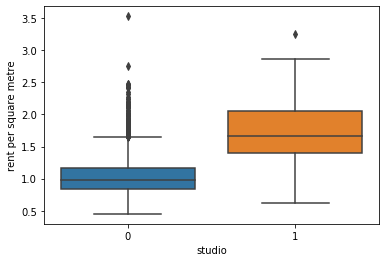

In [160]:
sb.boxplot(x=df['studio'], y=df['rent']/df['area'])
plt.ylabel('rent per square metre')
plt.show()

We  will now compare MAE and MAPE (in terms of source non-logged target) of the linear models built on the base and test feature sets.

In [0]:
#computing metrics for regression on the base feature set
lin_base_train_scores = {}
lin_base_train_scores['MAE'] = round(mae(np.exp(ln_y_base_train), np.exp(ln_y_base_train_pred)),
                                     2)
lin_base_train_scores['MAPE'] = round(mae(ln_y_base_train, ln_y_base_train_pred),
                                     2)
lin_base_test_scores = {}
lin_base_test_scores['MAE'] = round(mae(np.exp(ln_y_base_test), np.exp(ln_y_base_test_pred)),
                                    2)
lin_base_test_scores['MAPE'] = round(mae(ln_y_base_train, ln_y_base_train_pred),
                                     2)

In [0]:
#computing metrics for regression on the full feture set
lin_train_scores = {}
lin_train_scores['MAE'] = round(mae(np.exp(ln_y_train_pred), np.exp(ln_y_train)),
                                2)
lin_train_scores['MAPE'] = round(mae((ln_y_train_pred), (ln_y_train)),
                                 2)
lin_test_scores = {}
lin_test_scores['MAE'] = round(mae(np.exp(ln_y_test_pred), np.exp(ln_y_test)),
                                    2)
lin_test_scores['MAPE'] = round(mae(ln_y_test_pred, ln_y_test),
                                2)

The results show that adding extra parameters to the base set does not significantly improve regression performance. Although 14% MAPE is not bad anyway.

In [145]:
print(
'Linear regresion results \n\n'
'Base feature set \n'
'train: ', lin_base_train_scores,'\n'
'test:  ', lin_base_test_scores,'\n\n'
'Full feature set \n'
'train: ', lin_train_scores,'\n'
'test:  ', lin_test_scores
)

Linear regresion results 

Base feature set 
train:  {'MAE': 6.25, 'MAPE': 0.15} 
test:   {'MAE': 6.08, 'MAPE': 0.15} 

Full feature set 
train:  {'MAE': 5.87, 'MAPE': 0.14} 
test:   {'MAE': 5.91, 'MAPE': 0.14}


# Random forest
For random forest (rf) we will use *rent* as is (without taking log). The number of observations we have is quite small, so we will try to prevent overfitting by varying *min_samples_leaf* parameter, which will be selected based on 4-fold cross validation. 

In [0]:
y_base_train = df.loc[ln_y_base_train.index, 'rent']
y_base_test = df.loc[ln_y_base_test.index, 'rent']

In [147]:
#fitting rf on the base feature set
rf_base_cv = GridSearchCV(RandomForestRegressor(criterion='mae'),
                            {'min_samples_leaf': list(range(1, 100, 5)),
                             'n_estimators': [50, 100, 150, 200]
                            },
                            cv=4,
                            n_jobs=-1
                        )
rf_base_cv.fit(X_base_train, y_base_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mae',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 3, 4, 

In [0]:
def mape(y_true, y_pred):
    return (np.abs(y_true-y_pred)/np.abs(y_true)).sum()/len(y_true)

In [0]:
y_train = df.loc[ln_y_train.index, 'rent']
y_test = df.loc[ln_y_test.index, 'rent']

In [0]:
#fitting rf on the full feature set
rf_cv = GridSearchCV(RandomForestRegressor(criterion='mae'),
                    {'min_samples_leaf': list(range(1, 150, 5)),
                     'n_estimators': [50, 100, 150, 200]
                    },
                    cv=4,
                    n_jobs=-1
                    )

In [152]:
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mae',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'min_samples_leaf': [5, 10, 15, 2

In [0]:
rf_base_train_scores = {}
rf_base_train_scores['MAE'] = round(mae(rf_cv.predict(X_train), y_train), 2)
rf_base_train_scores['MAPE'] = round(mape(rf_cv.predict(X_train), y_train), 2)
rf_base_test_scores = {}
rf_base_test_scores['MAE'] = round(mae(rf_cv.predict(X_test), y_test), 2)
rf_base_test_scores['MAPE'] = round(mape(rf_cv.predict(X_test), y_test), 2)
rf_train_scores = {}
rf_train_scores['MAE'] = round(mae(rf_cv.predict(X_train), y_train), 2)
rf_train_scores['MAPE'] = round(mape(rf_cv.predict(X_train), y_train), 2)
rf_test_scores = {}
rf_test_scores['MAE'] = round(mae(rf_cv.predict(X_test), y_test), 2)
rf_test_scores['MAPE'] = round(mape(rf_cv.predict(X_test), y_test), 2)

Metrics say that rf overfitted a bit stronger than linear regression and shows similar quality on the test set. Again, adding extra variables to the base feature set was not very helpful.

In [162]:
print(
'Random forest results \n\n'
'Base feature set \n'
'train: ', rf_base_train_scores,'\n'
'test:  ', rf_base_test_scores,'\n\n'
'Full feature set \n'
'train: ', rf_train_scores,'\n'
'test:  ', rf_test_scores,
)

Random forest results 

Base feature set 
train:  {'MAE': 4.44, 'MAPE': 0.11} 
test:   {'MAE': 5.87, 'MAPE': 0.14} 

Full feature set 
train:  {'MAE': 4.45, 'MAPE': 0.11} 
test:   {'MAE': 5.89, 'MAPE': 0.14}


Now we plot estimates predicted by rf versus actual rent prices:

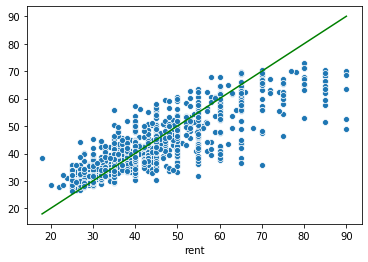

In [156]:
sb.scatterplot(x=y_train, y=rf_cv.predict(X_train))
plt.plot(sorted(y_train), sorted(y_train), color='green')  
plt.show()

The graph shows that the model stably underpredicts rent prices for flats with rental cost above 50 thousand. It means that rent price of such apartments is influenced by factors that are not present in our dataset.